In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/CV-Sem6/HW15")

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch import optim

from tqdm.auto import tqdm

import numpy as np
import cv2 as cv

from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt

In [ ]:
## Transform the data set ->> resize the images to 224x224 for using pre-defined architectures
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

### Download the dataset

In [ ]:
train_data = datasets.MNIST('./data/', download=True, train=True, transform=transform)
val_data = datasets.MNIST('./data/', download=True, train=False, transform=transform)

In [ ]:
## Set batch size for training and evaluation
train_batch_size = 8 
eval_batch_size = 8

# Q1 A

### Code for TSS based segmentation algorithm 

In [ ]:
## Create histogram for grayscale image
def create_hist(arr, nb_bins=256):
    hist, bin_edges = np.histogram(arr, bins=nb_bins) ## numpy in-built algo to create histogram
    
    ## calculate the center of the histoagram buckets/bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.
        
    return hist, bin_centres

In [ ]:
## TSS based segmentation
def tss_algo(image, nbins=256):
    
    flattent_img = image.ravel() ## Flatten the grayscale image 
    
    hist, bin_centers = create_hist(flattent_img, nbins) ## Create the histogram for the flattened grayscale image
    
    hist = hist/ np.sum(hist) ## normalizing histogram (taking out probability)
    
    tss_list = [] ## list to store the within class variance for all the threshold values
    
    for idx in range(1,256):
        
        ## calculate within class TSS for below the threshold
        left_arr = hist[:idx] ## count values below the threshold
        left_wt = bin_centers[:idx] 
        
        mu_1 = np.average(left_wt, weights=left_arr) ## calculate the weighted mean of the intensities
        
        left_tss = np.dot((left_wt-mu_1)**2, left_arr) ## calculate the TSS of the intensities
        
        ## calculate within class TSS for above the threshold
        right_arr = hist[idx:] ## count values above the threshold
        right_wt = bin_centers[idx:] 
        
        mu_2 = np.average(right_wt, weights=right_arr) ## calculate the weighted mean of the intensities

        right_tss = np.dot((right_wt-mu_2)**2, right_arr) ## calculate the TSS of the intensities     
        
        
        ## Calculate the total TSS for the threshold 
        min_tss = left_tss + right_tss
        
        tss_list.append(min_tss) ## Store the within-class TSS in a list
        
    ## Index for the lowest TSS 
    idx_min = tss_list.index(min(tss_list))
    
    return bin_centers[idx_min] ## return the bin centers for that index i.e., the optimal threshold 

### Defining the dataset class

In [ ]:
class Q1A_Dataset(Dataset):

    def __init__(self, base_dataset):
        ## to use the inbuilt dataset object for MNIST from pytorch  
        self.base_dataset = base_dataset 
    
    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## index the base class for a sample
        img_arr, img_label = self.base_dataset[idx]

        ## Use the custom TSS algorithm for the threshold 
        threshold = tss_algo(img_arr.numpy())

        ## Create an empty mask 
        seg_mask = torch.zeros_like(img_arr)

        ## Create a binary mask based on the threshold
        seg_mask[img_arr < threshold] = 0
        seg_mask[img_arr >= threshold] = 1

        ## returning the class label with it as it used in subsequent parts
        return img_arr, seg_mask, img_label

In [ ]:
train_dataset_A = Q1A_Dataset(train_data)
train_data_loader_A = torch.utils.data.DataLoader(train_dataset_A, batch_size=train_batch_size, shuffle=True)

In [ ]:
val_dataset_A = Q1A_Dataset(val_data)
val_data_loader_A = torch.utils.data.DataLoader(val_dataset_A, batch_size=eval_batch_size, shuffle=True)

### Look at the new dataset

In [ ]:
print(f'Image shape: {train_dataset_A[0][0].shape}, segmentation mask shape: {train_dataset_A[0][1].shape}, Class label shape: {train_dataset_A[0][2]}')

Image shape: torch.Size([1, 224, 224]), segmentation mask shape: torch.Size([1, 224, 224]), Class label shape: 5


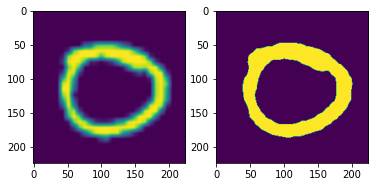

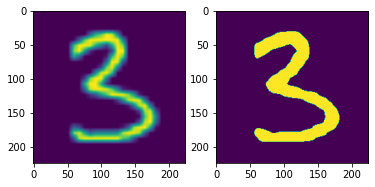

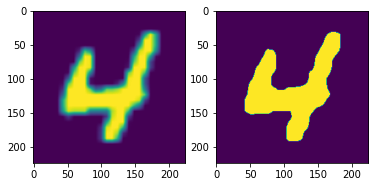

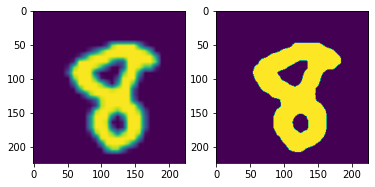

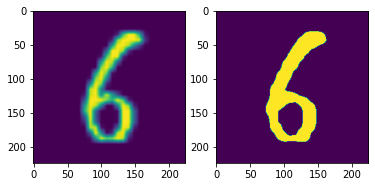

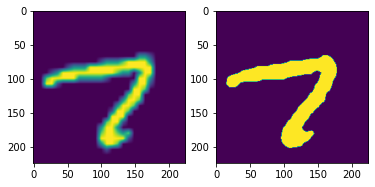

In [ ]:
batch = next(iter(train_data_loader_A))
image, mask, label = batch

for i in range(6):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image[i][0])
    ax2.imshow(mask[i][0])
    plt.show()

# Q1 B

### Defining dataset class

In [ ]:
class Q1B_Dataset(Dataset):

    def __init__(self, base_dataset):
        ## to use the dataset class formed in the last part 
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)

    ## Function to generate min enclosing circles for the digits
    def get_min_enc_circle(self, bin_seg_mask):
        
        ## binary mask corresponding to the thresholded value for the digit
        mask = bin_seg_mask.numpy()[0]

        ## Convert it into np.uint8 type for cv2
        mask = np.array(mask, dtype=np.uint8)
        h, w = mask.shape ## Shape of the image

        ## find the contours 
        contours,hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        ## look at the top most contour, as the empty shape in loops like 8, 0 wouldn't matter for the enclsing circle
        cnt = contours[0] 

        ## find the min enclosing circle corresponding to the contour
        (x,y),radius = cv.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radius = int(radius)

        ## keep -1 for filling the circle for jaccard score or +1 for visualizing the dataset
        circle_mask = cv.circle(mask,center,radius,(255,255), -1)

        ## final variable to be predicted for the circle
        bounding_circle = (x/h,y/w, radius/(((h**2 + w**2)**0.5)/2))

        return bounding_circle, circle_mask


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## index a sample from the q1a dataset
        img_arr, seg_mask, img_label = self.base_dataset[idx]

        ## create the enclosing circle 
        bounding_circle, circle_mask = self.get_min_enc_circle(seg_mask)

        ## convert to tensor and add unsqueeze the tensor for using in dataloader
        bounding_circle = torch.tensor(bounding_circle).type(torch.float32)
        circle_mask = torch.tensor(circle_mask).unsqueeze(0)

        return seg_mask, bounding_circle, img_label, circle_mask  

In [ ]:
train_dataset_B = Q1B_Dataset(train_dataset_A)
train_data_loader_B = torch.utils.data.DataLoader(train_dataset_B, batch_size=2*train_batch_size, shuffle=True)

In [ ]:
val_dataset_B = Q1B_Dataset(val_dataset_A)
val_data_loader_B = torch.utils.data.DataLoader(val_dataset_B, batch_size=2*eval_batch_size, shuffle=True)

### look at the new dataset

In [ ]:
print(f'Image shape: {train_dataset_B[0][0].shape}, bounding circle center: {train_dataset_B[0][1][:2]}, radius : {train_dataset_B[0][1][-1]}')

Image shape: torch.Size([1, 224, 224]), bounding circle center: tensor([0.4933, 0.5312]), radius : 0.6818529963493347


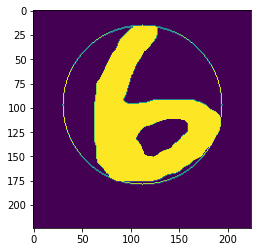

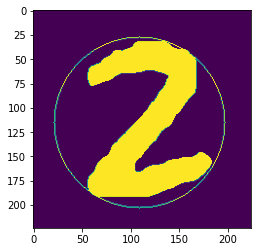

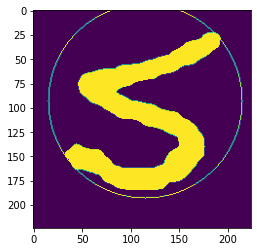

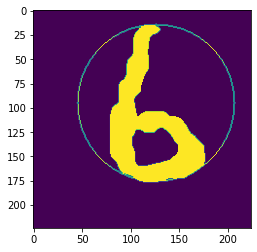

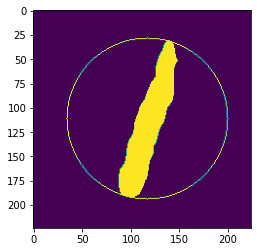

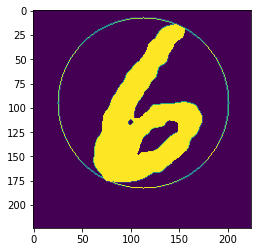

In [ ]:
a = next(iter(val_data_loader_B))

## take the digit images and the corresponding circle maps when (+1) is set
masks = a[-1]
imgs = a[0]

for i in range(6):
    final_image = imgs[i][0]*255 + masks[i][0]
    final_image = final_image > 120
    plt.imshow(final_image)
    plt.show()

### Modified Jaccard similarity score for taking into account the class label prediction as well

In [ ]:
def ModifiedJaccardSimilarity(mask_1, mask_2, preds, labels):

    ## Find a boolean mask for the 2 masks
    bool_mask_1 = mask_1 > 0
    bool_mask_2 = mask_2 > 0
    
    ## Find the intersection - Numerator 
    intersection = np.logical_and(bool_mask_1, bool_mask_2).sum(axis=1)
    # print(intersection.shape)
    
    ## Find the union - Denominator 
    union = np.logical_or(bool_mask_1, bool_mask_2).sum(axis=1)
    
    ## Jaccard Simmilarity Score 
    JS_score = intersection / union
    
    modified_JS = (preds==labels) * JS_score.numpy()
    
    return np.average(modified_JS)

In [ ]:
ModifiedJaccardSimilarity(a[0].reshape(2*eval_batch_size, -1), a[-1].reshape(2*eval_batch_size, -1), a[2], a[2])

0.3095477

# Q1 C

### Defining dataset class

In [ ]:
class Q1C_Dataset(Dataset):

    def __init__(self, base_dataset):
        
        self.base_dataloader = torch.utils.data.DataLoader(base_dataset, batch_size=4, shuffle=True) 
    
    def __len__(self):
        return len(self.base_dataloader)
    
    ## function for concatenating images in a 2x grid fashion 
    def concat_samples(self,img_arr):
        
        ## store image size
        nb_images, nb_channels, h, w = img_arr.shape

        ## create an empty placeholder based on the number and size of images 
        new_img_arr = torch.zeros((nb_channels, 2*h, w*(nb_images//2)))

        idx = 0
        ## concatenate individual images 
        for row in range(2):
            for col in range(nb_images//2):
                new_img_arr[:, col*h : (col+1)*h, row*w : (row+1)*w] = img_arr[idx]
                idx +=1
        
        return new_img_arr

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## take a random batch of 4 images
        img_arr, seg_mask, img_label = next(iter(self.base_dataloader))

        ## Concatenate those 4 samples 
        img_arr = self.concat_samples(img_arr)
        
        ## Concatenate the segmentation masks corresponding to those 4 samples 
        seg_mask = self.concat_samples(seg_mask*(img_label+1).reshape((img_label.shape[0], 1, 1, 1)))
        ## Here we multiple each segmentation maske with its (label+1) value 
        ## such that the bg remains 0 but the digit label turn to label +1 
        ## used for semantic segmentation 

        return img_arr, seg_mask, img_label

In [ ]:
train_dataset_C = Q1C_Dataset(train_dataset_A)
train_data_loader_C = torch.utils.data.DataLoader(train_dataset_C, batch_size=train_batch_size, shuffle=True)

In [ ]:
val_dataset_C = Q1C_Dataset(train_dataset_A)
val_data_loader_C = torch.utils.data.DataLoader(train_dataset_C, batch_size=eval_batch_size, shuffle=True)

### look at the new dataset

In [ ]:
a = next(iter(val_data_loader_C))
img_arr, seg_mask, img_label = a

Different labels present in the groundtruth segmentation label: [0. 2. 4.]


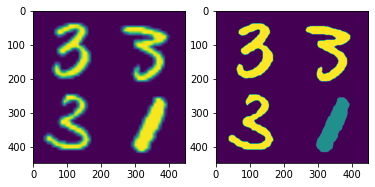

Different labels present in the groundtruth segmentation label: [0. 3. 6. 7.]


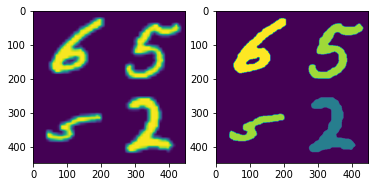

Different labels present in the groundtruth segmentation label: [ 0.  1.  4.  9. 10.]


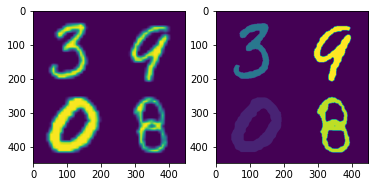

Different labels present in the groundtruth segmentation label: [ 0.  3.  4.  7. 10.]


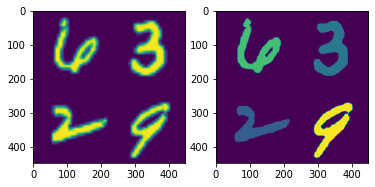

Different labels present in the groundtruth segmentation label: [ 0.  1.  4.  9. 10.]


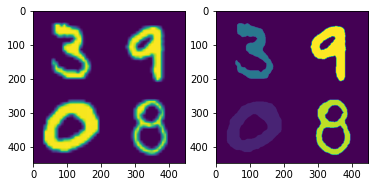

Different labels present in the groundtruth segmentation label: [ 0.  2.  4.  6. 10.]


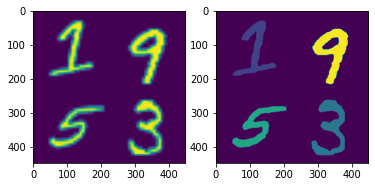

In [ ]:
for i in range(6):
    print(f'Different labels present in the groundtruth segmentation label: {np.unique(seg_mask[i][0], return_counts=False)}')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img_arr[i][0])
    ax2.imshow(seg_mask[i][0])
    plt.show()

# Train Function 2

In [ ]:
def train_func(model, criterion, train_dataloader, eval_dataloader, device, epochs, optimizer, max_train_steps_epoch=None, max_eval_steps_epoch=None, model_dir=None):
    
    ## load the model  
    model.to(device)

    ## keep track of different metrics 
    train_losses = []
    eval_losses = []
    eval_js = []

    ## decide the max steps for training
    if max_train_steps_epoch is None:
        max_train_steps_epoch = len(train_dataloader)

    max_train_steps = epochs * max_train_steps_epoch

    ## decide the max steps for evaluation 
    if max_eval_steps_epoch is None:
        max_eval_steps_epoch = len(eval_dataloader)

    progress_bar_train = tqdm(range(max_train_steps))
    
    completed_steps = 0

    for epoch in range(epochs):

        model.train() ## set the model to train
        progress_bar_train.set_description(f"Traing Epoch {epoch+1}", refresh=True)
        completed_steps_epoch = 0

        epoch_loss_train = 0

        ## Loop over each batch 
        for step, batch in enumerate(train_dataloader):
            
            ## put each component onto the device 
            img, seg, label = tuple(t.to(device) for t in batch)
            
            model.zero_grad()

            # Perform a forward pass
            logits = model(img)['out']

            ## Flatten the out predictions and labels to use pre-defined loss
            logits = logits.view(-1)
            seg = seg.view(-1)
            
            ## Calculate the loss
            loss = criterion(logits, seg)

            # Calculate gradient and take a step
            loss.backward()
            optimizer.step()
            
            epoch_loss_train += loss.item() ## store the loss

            progress_bar_train.set_postfix(batch_loss=loss.item())
            progress_bar_train.update(1)

            ## Print progress after some steps or if the training is complete 
            completed_steps_epoch += 1
            completed_steps += 1
            if completed_steps % 500 == 0 or completed_steps == max_train_steps:
                print("Training Loss: ", completed_steps, " --", epoch_loss_train/(step+1))

            ## Save the model after some steps or if the training is complete 
            if model_dir is not None and ((completed_steps % 500) == 0 or completed_steps == max_train_steps):
                model_name = f'{model_dir}_{completed_steps}.pt'
                torch.save({
                            "completed_steps": completed_steps,
                            "model_state_dict": model.state_dict()
                            }, model_name)
        
            if completed_steps_epoch >= max_train_steps_epoch:
                break

        train_losses.append(epoch_loss_train/max_train_steps_epoch)

        ## Set the model to evaluation after one training epoch 
        model.eval()
        
        progress_bar_eval = tqdm(range(max_eval_steps_epoch), leave=False)
        completed_steps_epoch_eval = 0
        progress_bar_eval.set_description(f"Evaluation after {epoch} Epoch", refresh=True)

        ## store the evaluation metrics 
        epoch_js_eval = 0
        epoch_loss_eval = 0

        ## Loop over each batch 
        for step, batch in enumerate(eval_dataloader):
            
            ## put each component onto the device 
            img, seg, label = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                logits = model(img)['out']

            ## Flatten the out predictions and labels to use pre-defined loss
            logits = logits.view(-1)
            seg = seg.view(-1)

            ## Calculate the loss
            loss = criterion(logits, seg)

            ## convert logits into labels 
            preds = (logits > 0.5).cpu().float().numpy()

            ## Calculate the jaccard score 
            epoch_js_eval += jaccard_score(seg.cpu().numpy(), preds)

            ## Store loss
            epoch_loss_eval += loss.item()

            completed_steps_epoch_eval += 1

            progress_bar_eval.set_postfix(batch_loss=loss.item())
            progress_bar_eval.update(1)

            if completed_steps_epoch_eval >= max_eval_steps_epoch:
                break

        eval_losses.append(epoch_loss_eval/max_eval_steps_epoch)
        eval_js.append(epoch_js_eval/max_eval_steps_epoch)

        print("Evaluation Loss:", epoch+1, "--", eval_losses[-1], "-- Evaluation Jaccard Score:", eval_js[-1])
    
    return train_losses, eval_losses, eval_js

# Train Function (3)

### Function that calculate the jaccard score after creating circles from the predicted center and radius values

In [ ]:
## Calculates jaccard similarity score 
def eval_metric(preds, labels, out_reg, circle_map):

    ## Store generated circle aps 
    circle_maps = []
    metric = 0

    ## For each prediction convert center + radius -> circle 
    for idx in range(circle_map.shape[0]):
        h, w = circle_map.shape[-2:]

        ## create an empty mask 
        mask = np.zeros((circle_map.shape[-2:]))

        ## store the center and radius out of the regression outputs 
        center = (int(out_reg[idx, 0] * h), int(out_reg[idx, 1] * w))
        radius = int(out_reg[idx, 2] * ((h**2 + w**2)**0.5)/2)

        ## create a circle map 
        circle_maps.append(cv.circle(mask,center,radius,(255,255), -1))

    ## concatenate into an array
    pred_circle_map = np.array(circle_maps)

    ## Calculate modified jaccard score based on the predicted label 
    metric = ModifiedJaccardSimilarity(pred_circle_map.reshape((preds.shape[0], -1)), circle_map.reshape((preds.shape[0], -1)), preds, labels)

    return metric

### Training and evaluation loop

In [ ]:
def train_func_3(model, criterions, train_dataloader, eval_dataloader, device, epochs, optimizer, max_train_steps_epoch=None, max_eval_steps_epoch=None, model_dir=None):
    model.to(device)

    ## store classification and regression loss functions 
    criterion_class = criterions[0]
    criterion_reg = criterions[1]

    ## keep track of different metrics 
    train_losses_class = []
    train_losses_reg = []

    eval_losses_class = []
    eval_losses_reg = []

    evaluation_metric = []

    ## decide the max steps for training
    if max_train_steps_epoch is None:
        max_train_steps_epoch = len(train_dataloader)

    max_train_steps = epochs * max_train_steps_epoch

    ## decide the max steps for evaluation 
    if max_eval_steps_epoch is None:
        max_eval_steps_epoch = len(eval_dataloader)

    progress_bar_train = tqdm(range(max_train_steps))
    
    completed_steps = 0

    for epoch in range(epochs):
        model.train()
        progress_bar_train.set_description(f"Traing Epoch {epoch+1}", refresh=True)
        completed_steps_epoch = 0

        epoch_loss_train_class = 0
        epoch_loss_train_reg = 0
        metric = 0
        for step, batch in enumerate(train_dataloader):
            
            img, bounding_cicle, label = tuple(t.to(device) for t in batch[:3])
            
            model.zero_grad()

            # Perform a forward pass
            logits_class, out_reg = model(img)

            loss_class = criterion_class(logits_class, label)
            loss_reg = criterion_reg(out_reg, bounding_cicle)

            # print(loss_class.item(), loss_reg.item())
            loss = loss_class + loss_reg

            # Calculate gradient and take a step
            loss.backward()
            optimizer.step()
            
            epoch_loss_train_class += loss.item()
            epoch_loss_train_reg += loss_reg.item()
            
            progress_bar_train.set_postfix(batch_loss=loss.item())
            progress_bar_train.update(1)

            completed_steps_epoch += 1
            completed_steps += 1

            ## Print progress after some steps or if the training is complete
            if completed_steps % 500 == 0 or completed_steps == max_train_steps:
                print("Training Loss: ", completed_steps, " -- Class --", epoch_loss_train_class/(step+1), " -- Class --", epoch_loss_train_reg/(step+1))

            ## Save the model after some steps or if the training is complete 
            if model_dir is not None and ((completed_steps % 500) == 0 or completed_steps == max_train_steps):
                model_name = f'{model_dir}_{completed_steps}.pt'
                torch.save({
                            "completed_steps": completed_steps,
                            "model_state_dict": model.state_dict()
                            }, model_name)
        
            if completed_steps_epoch >= max_train_steps_epoch:
                break

        train_losses_class.append(epoch_loss_train_class/max_train_steps_epoch)
        train_losses_reg.append(epoch_loss_train_reg/max_train_steps_epoch)

        ## Set the model to evaluation after one training epoch
        model.eval()
        
        progress_bar_eval = tqdm(range(max_eval_steps_epoch), leave=False)
        completed_steps_epoch_eval = 0
        progress_bar_eval.set_description(f"Evaluation after {epoch} Epoch", refresh=True)
        
        ## store the evaluation metrics 
        epoch_loss_eval_class = 0
        epoch_loss_eval_reg = 0
        metric = 0

        ## Loop over each batch 
        for step, batch in enumerate(eval_dataloader):
            
            ## put each component onto the device 
            img, bounding_cicle, label = tuple(t.to(device) for t in batch[:3])

            with torch.no_grad():
                logits_class, out_reg = model(img)

            ## Calculate the loss for classification and regularization task
            loss_class = criterion_class(logits_class, label)
            loss_reg = criterion_reg(out_reg, bounding_cicle)

            loss = loss_class + loss_reg

            ## Store loss
            epoch_loss_eval_class += loss_class.item()
            epoch_loss_eval_reg += loss_reg.item()

            completed_steps_epoch_eval += 1

            ## convert logits into labels 
            preds = torch.argmax(logits_class, dim=1).flatten().cpu().numpy()

            ## Calculate the jaccard score  (multilabel therefore micro averaging)
            metric += eval_metric(preds, label.cpu().numpy(), out_reg.cpu().numpy(), img.cpu()) 

            progress_bar_eval.set_postfix(batch_loss=loss.item())
            progress_bar_eval.update(1)

            if completed_steps_epoch_eval >= max_eval_steps_epoch:
                break

        eval_losses_class.append(epoch_loss_eval_class/max_eval_steps_epoch)
        eval_losses_reg.append(epoch_loss_eval_reg/max_eval_steps_epoch)
        evaluation_metric.append(metric/max_eval_steps_epoch)

        print("Evaluation Loss - :", epoch+1, "--Class -- ", eval_losses_class[-1], "--Reg -- ", eval_losses_reg[-1], "-- Evaluation Jaccard Score:", evaluation_metric[-1])

    return train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric

In [ ]:
!nvidia-smi

Fri May  7 18:57:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train Function 4

In [ ]:
def train_func_4(model, criterion, train_dataloader, eval_dataloader, device, epochs, optimizer, max_train_steps_epoch=None, max_eval_steps_epoch=None, model_dir=None):
    
    ## load the model 
    model.to(device)

    ## keep track of different metrics 
    train_losses = []
    eval_losses = []
    eval_js = []

    ## decide the max steps for training
    if max_train_steps_epoch is None:
        max_train_steps_epoch = len(train_dataloader)

    max_train_steps = epochs * max_train_steps_epoch

    ## decide the max steps for evaluation 
    if max_eval_steps_epoch is None:
        max_eval_steps_epoch = len(eval_dataloader)

    progress_bar_train = tqdm(range(max_train_steps))
    
    completed_steps = 0

    for epoch in range(epochs):

        model.train() ## set the model to train
        progress_bar_train.set_description(f"Traing Epoch {epoch+1}", refresh=True)
        completed_steps_epoch = 0

        epoch_loss_train = 0

        ## Loop over each batch 
        for step, batch in enumerate(train_dataloader):

            ## put each component onto the device 
            img, seg, label = tuple(t.to(device) for t in batch)
            
            model.zero_grad()

            # Perform a forward pass
            logits = model(img)['out']

            ## Reshape the prediction as (batch_size*image_h*image_w, nb_classes) 
            logits = logits.permute(0, 2, 3, 1).reshape(-1, 11)

            ## Reshape the labels as (batch_size*image_h*image_w, )
            seg = seg.reshape(-1,).long()

            loss = criterion(logits, seg)

            # Calculate gradient and take a step
            loss.backward()
            optimizer.step()
            
            ## Calculate the loss
            epoch_loss_train += loss.item()
 
            progress_bar_train.set_postfix(batch_loss=loss.item())
            progress_bar_train.update(1)

            ## Print progress after some steps or if the training is complete 
            completed_steps_epoch += 1
            completed_steps += 1
            if completed_steps % 500 == 0 or completed_steps == max_train_steps:
                print("Training Loss: ", completed_steps, " --", epoch_loss_train/(step+1))

            ## Save the model after some steps or if the training is complete 
            if model_dir is not None and ((completed_steps % 500) == 0 or completed_steps == max_train_steps):
                model_name = f'{model_dir}_{completed_steps}.pt'
                torch.save({
                            "completed_steps": completed_steps,
                            "model_state_dict": model.state_dict()
                            }, model_name)
        
            if completed_steps_epoch >= max_train_steps_epoch:
                break

        train_losses.append(epoch_loss_train/max_train_steps_epoch)

        ## Set the model to evaluation after one training epoch
        model.eval()
        
        progress_bar_eval = tqdm(range(max_eval_steps_epoch), leave=False)
        completed_steps_epoch_eval = 0
        progress_bar_eval.set_description(f"Evaluation after {epoch} Epoch", refresh=True)

        ## store the evaluation metrics 
        epoch_js_eval = 0
        epoch_loss_eval = 0

        ## Loop over each batch 
        for step, batch in enumerate(eval_dataloader):
            
            ## put each component onto the device 
            img, seg, label = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                logits = model(img)['out']
            
            ## Reshape the prediction as (batch_size*image_h*image_w, nb_classes) 
            logits = logits.permute(0, 2, 3, 1).reshape(-1, 11)

            ## Reshape the labels as (batch_size*image_h*image_w, )
            seg = seg.view(-1,).long()

            ## Calculate the loss
            loss = criterion(logits, seg)

            ## convert logits into labels 
            preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()

            ## Calculate the jaccard score  (multilabel therefore micro averaging)
            epoch_js_eval += jaccard_score(seg.cpu().numpy(), preds, average='micro')

            ## Store loss
            epoch_loss_eval += loss.item()

            completed_steps_epoch_eval += 1

            progress_bar_eval.set_postfix(batch_loss=loss.item())
            progress_bar_eval.update(1)

            if completed_steps_epoch_eval >= max_eval_steps_epoch:
                break

        eval_losses.append(epoch_loss_eval/max_eval_steps_epoch)
        eval_js.append(epoch_js_eval/max_eval_steps_epoch)

        print("Evaluation Loss:", epoch+1, "--", eval_losses[-1], "-- Evaluation Jaccard Score:", eval_js[-1])
    
    return train_losses, eval_losses, eval_js

# Q2

In [ ]:
## Run for 3 epochs 
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

## initiallize a pre-defined model
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)

## convert the first layer to 1 dimension (change as pre-defined for 3 dims on image-net)
setattr(list(fcn.named_children())[0][1], 'conv1', nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

## Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## initalize optimizer
optimizer = optim.SGD(fcn.parameters(), lr=0.001, momentum=0.9)

## define loss function 
loss_fn = nn.BCEWithLogitsLoss()

## Training loop
train_loss, val_loss, val_js = train_func(fcn, loss_fn, train_data_loader_A, 
                                          val_data_loader_A, device, EPOCHS, optimizer, 
                                          max_train_steps_epoch, max_eval_steps_epoch, 
                                          model_dir="./saved_models/q2")

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(val_js, label='Validation jaccard_score')
plt.legend()
plt.plot()

print(train_loss, val_loss, val_js)

### Find output (loading previously trained model)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## initiallize a pre-defined model
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)

## convert the first layer to 1 dimension (change as pre-defined for 3 dims on image-net)
setattr(list(fcn.named_children())[0][1], 'conv1', nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

## Load checkpoint
checkpoint = torch.load("./saved_models/q2_2814.pt")
fcn.load_state_dict(checkpoint['model_state_dict'])

fcn.to(device)

In [ ]:
## work on one batch 
a, b, c = next(iter(train_data_loader_A))
a = a.to(device)
out = fcn(a)['out']

In [ ]:
## Plot the predictions
for i in range(6):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(b[i].cpu().detach().numpy()[0])
    ax2.imshow(out[i].cpu().detach().numpy()[0])
    ax3.imshow(out[i].cpu().detach().numpy()[0]>0.5)
    plt.show()

# Q3

### Create the model for Q3

In [ ]:
class Q3_model(nn.Module):
    def __init__(self):
        super(Q2_model, self).__init__()

        ## take the backbone of VGG-19
        vgg = models.vgg19(pretrained=False)
        setattr(list(vgg.named_children())[0][1], '0', nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

        self.base_model = vgg

        ## Output number of classes 
        self.num_classes = 10

        ## radius, center_x, center_y
        self.num_reg = 3

        ## dropout layer
        self.dropout = nn.Dropout(p=0.5, inplace=False)

        ## fully connected layer for classification 
        self.fc_class = nn.Linear(1000, self.num_classes)

        ## fully-connected layer for regression
        self.fc_reg = nn.Sequential(
                                    nn.Linear(1000, 500),
                                    nn.ReLU(),
                                    nn.Linear(500, self.num_reg)
        )

    def forward(self, x):
        
        ## Base VGG
        x = self.dropout(nn.functional.relu(self.base_model(x)))

        ## logits for classification
        x_class = self.fc_class(x)

        ## regression output 
        x_reg = self.fc_reg(x)

        return x_class, x_reg

### Train model

In [ ]:
## Run for 3 epochs 
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

## intialize model 
model = Q3_model()

## set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## classification loss
loss_class = nn.CrossEntropyLoss()

## regression loss
loss_reg = nn.L1Loss()

## training loop
train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric = train_func_3(model, [loss_class, loss_reg], 
                                                                                                         train_data_loader_B, val_data_loader_B, 
                                                                                                         device, EPOCHS, optimizer, max_train_steps_epoch, 
                                                                                                         max_eval_steps_epoch, model_dir="./saved_models/q3")

print(train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric)

Evaluation Loss - : 1 --Class --  0.09120873847528349 --Reg --  0.23042940206920046 -- Evaluation Jaccard Score: 0.0932568125898325
Training Loss:  500  -- Class -- 0.2342554965326863  -- Class -- 0.07781115246395912


Evaluation Loss - : 2 --Class --  0.058030761796037986 --Reg --  0.1688046859035009 -- Evaluation Jaccard Score: 0.18330375227747084
Training Loss:  1000  -- Class -- 0.1521093177218591  -- Class -- 0.04834680685833577
Training Loss:  1407  -- Class -- 0.12894913203108793  -- Class -- 0.043703736439506126


Evaluation Loss - : 3 --Class --  0.04057603477665424 --Reg --  0.12124412214454217 -- Evaluation Jaccard Score: 0.24625522973416727
[0.9804218573483832, 0.18481809971556226, 0.12894913203108793] [0.13933889583738118, 0.061328297286336104, 0.043703736439506126] [0.09120873847528349, 0.058030761796037986, 0.04057603477665424] [0.23042940206920046, 0.1688046859035009, 0.12124412214454217] [0.0932568125898325, 0.18330375227747084, 0.24625522973416727]


In [ ]:
## second run 
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

model = Q3_model()

## load saved models 
checkpoint = torch.load("./saved_models/q3_1000.pt")
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_class = nn.CrossEntropyLoss()

loss_reg = nn.L1Loss()

train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric = train_func_3(model, [loss_class, loss_reg], 
                                                                                                         train_data_loader_B, val_data_loader_B, 
                                                                                                         device, EPOCHS, optimizer, max_train_steps_epoch, 
                                                                                                         max_eval_steps_epoch, model_dir="./saved_models/q3_2nd_run")

print(train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric)

Evaluation Loss - : 1 --Class --  0.040295759743503946 --Reg --  0.12095310680473907 -- Evaluation Jaccard Score: 0.24629454823988903
Training Loss:  500  -- Class -- 0.10064849654032339  -- Class -- 0.0381588252081025


Evaluation Loss - : 2 --Class --  0.034902003531851154 --Reg --  0.08135091503964195 -- Evaluation Jaccard Score: 0.28840680401536484
Training Loss:  1000  -- Class -- 0.08554414996216374  -- Class -- 0.0339479107830313
Training Loss:  1407  -- Class -- 0.08580065810127553  -- Class -- 0.03265784603001466


Evaluation Loss - : 3 --Class --  0.02693665253375716 --Reg --  0.06101879378474211 -- Evaluation Jaccard Score: 0.3115327395970308
[0.12505522879487924, 0.09930214188945319, 0.08580065810127553] [0.04262956441529016, 0.036097104746554455, 0.03265784603001466] [0.040295759743503946, 0.034902003531851154, 0.02693665253375716] [0.12095310680473907, 0.08135091503964195, 0.06101879378474211] [0.24629454823988903, 0.28840680401536484, 0.3115327395970308]


In [ ]:
## third run 
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

model = Q3_model()

checkpoint = torch.load("./saved_models/q3_2nd_run_1407.pt")
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_class = nn.CrossEntropyLoss()

loss_reg = nn.L1Loss()

train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric = train_func_3(model, [loss_class, loss_reg], 
                                                                                                         train_data_loader_B, val_data_loader_B, 
                                                                                                         device, EPOCHS, optimizer, max_train_steps_epoch, 
                                                                                                         max_eval_steps_epoch, model_dir="./saved_models/q3_3rd_run")

print(train_losses_class, train_losses_reg, eval_losses_class, eval_losses_reg, evaluation_metric)

Evaluation Loss - : 1 --Class --  0.023485587665934966 --Reg --  0.04409509208760684 -- Evaluation Jaccard Score: 0.33100705508944356
Training Loss:  500  -- Class -- 0.08352595976283474  -- Class -- 0.031129554334667422


Evaluation Loss - : 2 --Class --  0.023147276546319807 --Reg --  0.04246018643054781 -- Evaluation Jaccard Score: 0.33095624627946296
Training Loss:  1000  -- Class -- 0.05983968328444227  -- Class -- 0.030256877743428754
Training Loss:  1407  -- Class -- 0.06634972103114829  -- Class -- 0.029950519817184284


Evaluation Loss - : 3 --Class --  0.026495761522445593 --Reg --  0.03929165580981894 -- Evaluation Jaccard Score: 0.32999350036246866
[0.07867230127837613, 0.07149004029519142, 0.06634972103114829] [0.031027264535617726, 0.030199930333951387, 0.029950519817184284] [0.023485587665934966, 0.023147276546319807, 0.026495761522445593] [0.04409509208760684, 0.04246018643054781, 0.03929165580981894] [0.33100705508944356, 0.33095624627946296, 0.32999350036246866]


### Find output (loading model)

In [ ]:
model = Q3_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("./saved_models/q3_3rd_run_500.pt")
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

#### find jaccard score wrt groundtruth and predicted circles

In [ ]:
## set up evaluation process for 1 epoch 
max_eval_steps_epoch = len(val_data_loader_B)
progress_bar_eval = tqdm(range(max_eval_steps_epoch))
completed_steps_epoch_eval = 0
progress_bar_eval.set_description(f"Calculating Jaccard score on evaluation dataset ", refresh=True)

## define the two loss function 
criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.L1Loss()

epoch_loss_eval_class = 0
epoch_loss_eval_reg = 0
metric = 0

model.eval()

## loop over the batchs 
for step, batch in enumerate(val_data_loader_B):

    ## put each component onto the device 
    img, bounding_cicle, label = tuple(t.to(device) for t in batch[:3])

    with torch.no_grad():
        logits_class, out_reg = model(img)

    ## calculate loss
    loss_class = criterion_class(logits_class, label)
    loss_reg = criterion_reg(out_reg, bounding_cicle)

    loss = loss_class + loss_reg

    epoch_loss_eval_class += loss_class.item()
    epoch_loss_eval_reg += loss_reg.item()

    completed_steps_epoch_eval += 1

    ## convert logits into labels 
    preds = torch.argmax(logits_class, dim=1).cpu().numpy()

    ## Calculate the jaccard score  for the two circle masks 
    metric += eval_metric(preds, label.cpu().numpy(), out_reg.cpu().numpy(), batch[-1]) 

    progress_bar_eval.set_postfix(batch_loss=loss.item())
    progress_bar_eval.update(1)


epoch_loss_eval_class = epoch_loss_eval_class/max_eval_steps_epoch
epoch_loss_eval_reg = epoch_loss_eval_reg/max_eval_steps_epoch
metric = metric/max_eval_steps_epoch

print("Evaluation Loss - : --Class -- ", epoch_loss_eval_class, "--Reg -- ", epoch_loss_eval_reg, "-- Evaluation Jaccard Score:", metric)

Evaluation Loss - : --Class --  0.041841089320275936 --Reg --  0.029868647027015686 -- Evaluation Jaccard Score: 0.8338091256141663


#### look at predicted enclosing circles

In [ ]:
## take one batch
a, b, c, d = next(iter(train_data_loader_B))
a = a.to(device)

## find predictions
out = model(a)

In [ ]:
## separate class logits and regression outputs
logits_class, out_reg = out

## convert logits to labels 
preds = torch.argmax(logits_class, dim=1).flatten().cpu().numpy()
a = a.cpu().numpy()

Predicted class: 1| Actual class: 1
Predicted center (112, 111) | groundtruth center (111, 116) 
 Predicted radius 85 | groundtruth radius 81 



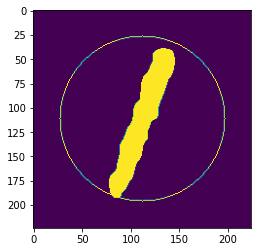

#######################################################3
Predicted class: 7| Actual class: 7
Predicted center (114, 138) | groundtruth center (94, 141) 
 Predicted radius 88 | groundtruth radius 95 



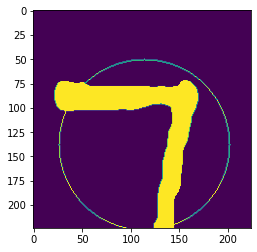

#######################################################3
Predicted class: 9| Actual class: 9
Predicted center (126, 133) | groundtruth center (103, 127) 
 Predicted radius 84 | groundtruth radius 83 



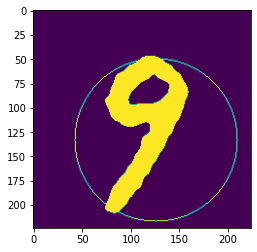

#######################################################3
Predicted class: 5| Actual class: 5
Predicted center (118, 107) | groundtruth center (110, 99) 
 Predicted radius 88 | groundtruth radius 86 



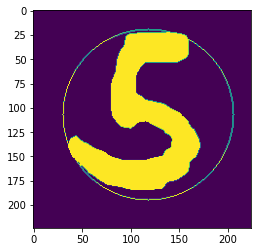

#######################################################3
Predicted class: 8| Actual class: 8
Predicted center (121, 121) | groundtruth center (129, 123) 
 Predicted radius 89 | groundtruth radius 89 



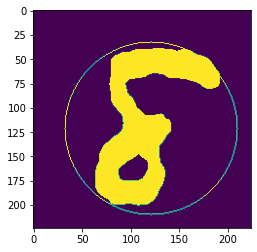

#######################################################3
Predicted class: 7| Actual class: 7
Predicted center (116, 120) | groundtruth center (113, 123) 
 Predicted radius 86 | groundtruth radius 74 



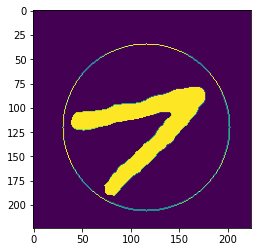

#######################################################3


In [ ]:
preds, labels, out_reg, circle_map = preds, c, out_reg, d

## print 6 examples
for idx in range(6):
    h, w = circle_map.shape[-2:]

    ## create an empty mask 
    mask = np.zeros((circle_map.shape[-2:]))

    ## calculate predicted center and radius values 
    center = (int(out_reg[idx, 0] * h), int(out_reg[idx, 1] * w))
    radius = int(out_reg[idx, 2] * ((h**2 + w**2)**0.5)/2)

    ## groundtruth values 
    gt_center = (int(b[idx, 0] * h), int(b[idx, 1] * w))
    gt_radius = int(b[idx, 2] * ((h**2 + w**2)**0.5)/2)
    
    print(f'Predicted class: {preds[idx]}| Actual class: {labels[idx]}')
    predicted_circle = cv.circle(mask,center,radius,(255,255), 1)

    print(f'Predicted center {center} | groundtruth center {gt_center} \n Predicted radius {radius} | groundtruth radius {gt_radius} \n')
    final_image = predicted_circle + (a[idx][0]*255)
    final_image = final_image > 120
    plt.imshow(final_image)
    plt.show()
    print('#######################################################3')

# Q4

In [ ]:
## Run for 3 epochs (got disconnected in between)
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

## Intiallize pre-defined model 
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=11)

## convert the first layer to 1 dimension (change as pre-defined for 3 dims on image-net)
setattr(list(fcn.named_children())[0][1], 'conv1', nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

## Set the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(fcn.parameters(), lr=0.001, momentum=0.9)

## Loss function 
loss_fn = nn.CrossEntropyLoss()

## training loop
train_loss, val_loss, val_js = train_func_4(fcn, loss_fn, train_data_loader_C, 
                                          val_data_loader_C, device, EPOCHS, optimizer, 
                                          max_train_steps_epoch, max_eval_steps_epoch, 
                                          model_dir="./saved_models/q4_new")

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(val_js, label='Validation jaccard_score')
plt.legend()
plt.plot()

print(train_loss, val_loss, val_js)

Training Loss:  500  -- 0.2050859679579735
Training Loss:  1000  -- 0.13345808175578713
Training Loss:  1500  -- 0.10346150029326479


Evaluation Loss: 1 -- 0.030049562719464303 -- Evaluation Jaccard Score: 0.9796881197700361
Training Loss:  2000  -- 0.03419701769948005
Training Loss:  2500  -- 0.031247120663523673
Training Loss:  3000  -- 0.029224600449204444
Training Loss:  3500  -- 0.027672353363380982


Evaluation Loss: 2 -- 0.019065229164560635 -- Evaluation Jaccard Score: 0.9868786288132684


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Training Loss:  500  -- 0.021973892757669092
Training Loss:  1000  -- 0.021007003918290138
Training Loss:  1500  -- 0.02047469298231105


Evaluation Loss: 1 -- 0.015466451747715474 -- Evaluation Jaccard Score: 0.9894209009750092
Training Loss:  2000  -- 0.01699028593301773
Training Loss:  2500  -- 0.01697497900277376
Training Loss:  3000  -- 0.016757856653796303
Training Loss:  3500  -- 0.016398098414907088


Evaluation Loss: 2 -- 0.012732319739460944 -- Evaluation Jaccard Score: 0.9912603010992661
Training Loss:  4000  -- 0.01381272365897894
Training Loss:  4500  -- 0.014130112908780575
Training Loss:  5000  -- 0.013806869278103113
Training Loss:  5500  -- 0.013632913842265094
Training Loss:  5625  -- 0.013559894005457561


Evaluation Loss: 3 -- 0.010922931196292241 -- Evaluation Jaccard Score: 0.9925160827276229


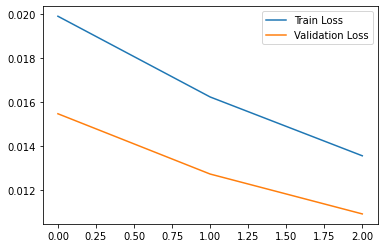

[0.019890019983549913, 0.016228977424899736, 0.013559894005457561] [0.015466451747715474, 0.012732319739460944, 0.010922931196292241] [0.9894209009750092, 0.9912603010992661, 0.9925160827276229]


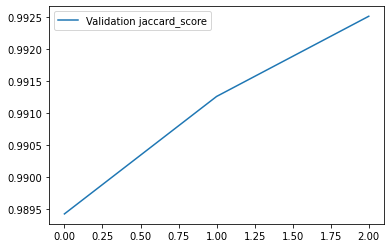

In [ ]:
## 2nd run loading previous model from check point 
EPOCHS = 3
max_train_steps_epoch = None
max_eval_steps_epoch = None

## init the model 
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=11)

## convert the first layer to 1 dimension (change as pre-defined for 3 dims on image-net)
setattr(list(fcn.named_children())[0][1], 'conv1', nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

## load the model from checkpoint 
checkpoint = torch.load("./saved_models/q4_new_3500.pt")
fcn.load_state_dict(checkpoint['model_state_dict'])

## set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(fcn.parameters(), lr=0.001, momentum=0.9)

## loss function 
loss_fn = nn.CrossEntropyLoss()

## training loop
train_loss, val_loss, val_js = train_func_4(fcn, loss_fn, train_data_loader_C, 
                                          val_data_loader_C, device, EPOCHS, optimizer, 
                                          max_train_steps_epoch, max_eval_steps_epoch, 
                                          model_dir="./saved_models/q4_new_2")

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(val_js, label='Validation jaccard_score')
plt.legend()
plt.plot()

print(train_loss, val_loss, val_js)

### look at generated outputs

In [ ]:
## initialize models 
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=11)

## convert the first layer to 1 dimension (change as pre-defined for 3 dims on image-net)
setattr(list(fcn.named_children())[0][1], 'conv1', nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

## load model from checkpoint
checkpoint = torch.load("./saved_models/q4_new_2_5625.pt")
fcn.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
fcn = fcn.to(device)

In [ ]:
## take one batch 
a, b, c = next(iter(train_data_loader_C))
a = a.to(device)

## calculate logits for them
out = fcn(a)['out']

In [ ]:
## convert them into semantic segmentation maps 
preds = torch.argmax(out, dim=1).cpu().numpy()

Different labels present in the groundtruth segmentation label: [0. 4. 5. 8. 9.]
Different labels present in the predicted segmentation label: [0 4 5 8 9]


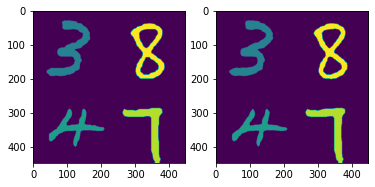

Different labels present in the groundtruth segmentation label: [0. 4. 7. 8.]
Different labels present in the predicted segmentation label: [0 4 7 8]


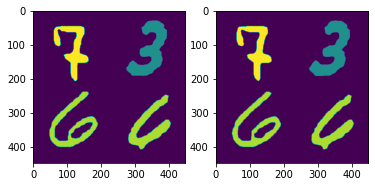

Different labels present in the groundtruth segmentation label: [ 0.  1.  3.  7. 10.]
Different labels present in the predicted segmentation label: [ 0  1  3  7  8 10]


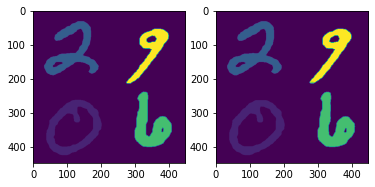

Different labels present in the groundtruth segmentation label: [0. 5. 8. 9.]
Different labels present in the predicted segmentation label: [0 5 8 9]


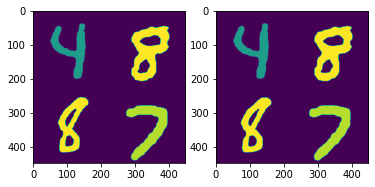

Different labels present in the groundtruth segmentation label: [ 0.  6.  9. 10.]
Different labels present in the predicted segmentation label: [ 0  6  9 10]


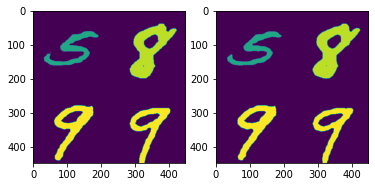

Different labels present in the groundtruth segmentation label: [ 0.  2.  3. 10.]
Different labels present in the predicted segmentation label: [ 0  2  3 10]


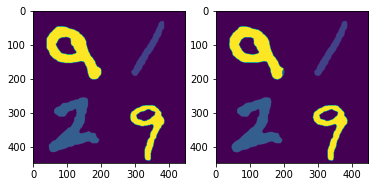

In [ ]:
## show 6 examples 
for i in range(6):
    print(f'Different labels present in the groundtruth segmentation label: {np.unique(b[i][0], return_counts=False)}')
    print(f'Different labels present in the predicted segmentation label: {np.unique(preds[i], return_counts=False)}')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(b[i][0])
    ax2.imshow(preds[i])
    plt.show()